# Building, Training and Evaluating the Convolutional Neural Network

Since we have completed our EDA, we will need to load our imageset. To begin, we will import the required Libraries.

# Importing Libraries

We will use the 'os' and 'Pillow' libraries to load/view the images stored in various sizes as 'numpy' arrays, which are stored in a 'pandas' dataframe, that was 'pickle'd. We will also use 'matplotlib's pyplot to visualize some of the intermediate acitvations within the CNN we will build using 'keras'.

In [0]:
import os
import PIL
from PIL import Image 
import pickle
import pandas as pd
import numpy as np   
from numpy import asarray
from matplotlib import image
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Since I am using Google Collab, I will check the GPU we are using for training our images. 

In [0]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11405050245022673308, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13604626954578021256
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15220161128665743783
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 129750288188969147
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

I can also check the memory I have available. 

In [0]:
!cat /proc/meminfo

MemTotal:       26751700 kB
MemFree:        22574436 kB
MemAvailable:   25135144 kB
Buffers:           76556 kB
Cached:          2681752 kB
SwapCached:            0 kB
Active:          1204800 kB
Inactive:        2481032 kB
Active(anon):     861108 kB
Inactive(anon):     8532 kB
Active(file):     343692 kB
Inactive(file):  2472500 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               816 kB
Writeback:             0 kB
AnonPages:        927784 kB
Mapped:           663204 kB
Shmem:              9140 kB
Slab:             198216 kB
SReclaimable:     134824 kB
SUnreclaim:        63392 kB
KernelStack:        4480 kB
PageTables:         8868 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13375848 kB
Committed_AS:    3436488 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1840 kB
AnonHugePages:   

# Loading the DataFrame from Pickle & Previewing the Images with PyPlot

Here we will use pickle to load our saved dataframe, and preview some of the images.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'numpy.ndarray'>


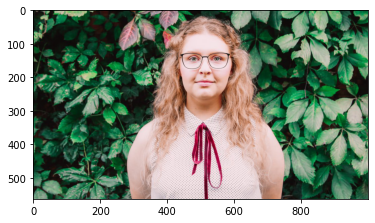

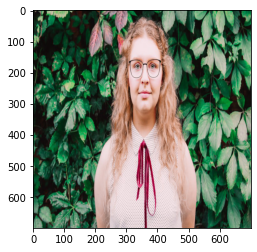

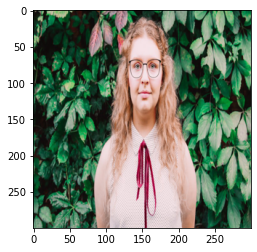

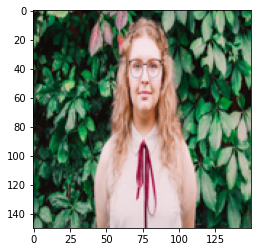

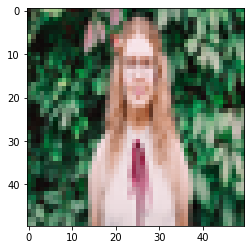

In [0]:
 ## Mounting google drive to access pickle file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data = pickle.load( open( "/content/drive/My Drive/Colab Notebooks/data_pickle_final.p", "rb" ) )
size_list = data.iloc(0)[0][-5:]
size_list[0]

print(type(size_list[0]))

for i in size_list:
    pyplot.imshow(i)
    pyplot.show();

# Previewing the DataFrame

Here we can see the different images formats and other data saved in our imageset. 

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271 entries, 0 to 2270
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Image_Links        2271 non-null   object
 1   Labels             2271 non-null   object
 2   MinMax             2271 non-null   object
 3   dtype              2271 non-null   object
 4   shape              2271 non-null   object
 5   img_data_original  2271 non-null   object
 6   img_data_700       2271 non-null   object
 7   img_data_300       2271 non-null   object
 8   img_data_150       2271 non-null   object
 9   img_data_50        2271 non-null   object
dtypes: object(10)
memory usage: 177.5+ KB


# Defining Feature Variables

The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255. Typically zero is taken to be black, and 255 is taken to be white. Values in between make up the different shades of gray. In our example we will be using color photos with that share the scale for red, green and blue, ie: 'rbg'; where 0 is no light and 255 is maximum light.  We will normalize the values by dividing each value by the maximum number in the range. 

In [0]:
X = data.img_data_300
X = X/255

print(type(X))

X.shape

X[0].shape

<class 'pandas.core.series.Series'>


(300, 300, 3)

# Creating a Tensor


Since we have each image stored as a numpy array, we will reformat the features into tensors for our neural network. 

In [0]:
tensor = np.zeros((X.shape[0],300,300,3))
for idx, i in enumerate(X):
    print(i)
    tensor[idx] = i


tensor.shape

Streaming output truncated to the last 5000 lines.
  [0.43137255 0.45098039 0.4745098 ]]]
[[[0.         0.69019608 0.78039216]
  [0.         0.69019608 0.78039216]
  [0.         0.69019608 0.78039216]
  ...
  [0.         0.68627451 0.79607843]
  [0.         0.68627451 0.8       ]
  [0.         0.68627451 0.8       ]]

 [[0.         0.69019608 0.78039216]
  [0.         0.69019608 0.78039216]
  [0.         0.69019608 0.78039216]
  ...
  [0.         0.68627451 0.79607843]
  [0.         0.68627451 0.8       ]
  [0.         0.68627451 0.8       ]]

 [[0.         0.69019608 0.78039216]
  [0.         0.69019608 0.78039216]
  [0.         0.69019608 0.78039216]
  ...
  [0.         0.68627451 0.79607843]
  [0.         0.68627451 0.8       ]
  [0.         0.68627451 0.8       ]]

 ...

 [[0.09019608 0.35294118 0.38823529]
  [0.09019608 0.35294118 0.38823529]
  [0.09019608 0.35294118 0.38823529]
  ...
  [0.         0.53333333 0.63529412]
  [0.         0.53333333 0.63529412]
  [0.         0.5333333

(2271, 300, 300, 3)

# Defining Target Variables

Here we will define our target variables. Since we combined two custom datasets to form our imageset, we will first convert our Labels into binary targets for our Neural Network. 

In [0]:
target = []
for i in data['Labels']:
  print(i)
  if i == 'shaved':
    target.append(0)
  elif i == 'unshaved':
    target.append(1)

shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved
shaved

For quick lesson, we will add the new binary targets to our dataframe an also define the target variable as 'y'.

In [0]:
len(target), len(data)

(2271, 2271)

In [0]:
data['target'] = target
y = data.target

y.shape

(2271,)

# Train-Test-Evaluation Split : Features-Target

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tensor[:-100], 
                                                    y[:-100], 
                                                    test_size=0.20, 
                                                    random_state=42)

# size of test/train split
for i in [X_train, X_test, y_train, y_test]:
    print(len(i))

# final evaluation data
evals_tensors = tensor[-100:]
evals_targets = y[-100:]
print(evals_tensors.shape,"\n #### \n", evals_targets)

1736
435
1736
435
(100, 300, 300, 3) 
 #### 
 2171    1
2172    1
2173    1
2174    1
2175    1
       ..
2266    1
2267    1
2268    1
2269    1
2270    1
Name: target, Length: 100, dtype: int64


# Building a Convolutional Neural Network (CNN)

Here we will build the layers to our Convolutional Neural Network. We will start by adding a sequential layer. We will also utilize 2D convolutional layers, Max pooling layers, Dense layers, and Dropout layers. 

In [0]:
model = Sequential()
model.add(Conv2D(32,(4,4),activation='relu',input_shape=(300,300,3)))
model.add(Conv2D(32,(4,4),activation='relu', padding='same'))
model.add(Conv2D(128,(4,4),activation='relu', padding='same'))
model.add(Conv2D(128,(4,4),activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.3))
model.add(Conv2D(256, (4,4), activation='relu', padding='same'))
model.add(Conv2D(256, (4,4), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.3))
model.add(MaxPooling2D((2, 2)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# # original the model @ 68% accuracy

# model2 = Sequential()
# model2.add(Conv2D(32,(4,4),activation='relu',input_shape=(150,150,3)))
# model2.add(Conv2D(32,(4,4),activation='relu'))
# model2.add(Conv2D(32,(4,4),activation='relu'))
# model2.add(Conv2D(32,(4,4),activation='relu'))
# model2.add(MaxPooling2D((2, 2)))
# model2.add(Conv2D(64, (4,4), activation='relu'))
# model2.add(Conv2D(64, (4,4), activation='relu'))
# model2.add(MaxPooling2D((2, 2)))
# model2.add(MaxPooling2D((2, 2)))
# model2.add(Flatten())
# model2.add(Dense(32, activation='relu'))
# model2.add(Dense(1, activation='sigmoid'))
# model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 297, 297, 32)      1568      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 297, 297, 32)      16416     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 297, 297, 128)     65664     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 297, 297, 128)     262272    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 148, 148, 128)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 148, 148, 128)     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 148, 148, 256)    

## Compiling, Fitting and Evaluating Model


Now that we have built our CNN model, we will need to compile, fit and evaluate the model. We will use early stopping to help us identify the global minimun for our binary crossentropy loss function. We will store the accuracy and loss metrics for each epoch in order to visualize the model performace over time.

In [ ]:
import time
start_time = time.time()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) 

history = model.fit(X_train, y_train,
                      batch_size=128, epochs=1000, 
                      validation_data=(X_test, y_test),
                      callbacks=[es], verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))

train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

## Plot Metric Performance History

Here we will use PyPlot to visualize our model's performance during training and testing.

In [0]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Training vs Test Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title('Training vs Test Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

## Evaluation


Now that we have our model, we will use it to make predictions on our hold-out evaluation set. The model has not seen this data, and should be able to make an accurate prediction. Let's take a look at the evaluation targets vs the predictions, and also take a look at the images in the evaluation imageset.

In [0]:
res = model.predict(evals_tensors)

In [ ]:
for i, j, k in zip(res, evals_tensors, evals_targets):
    if i >= .5:
      _ = 'Unshaved'
    else:
      _ = 'Shaved'
        print('Prediction:', round(i[0],2), '-',_)
    print('Actual:', k)
    pyplot.imshow(j)
    pyplot.show();

# Building a CNN using Transfer Learning

Here we will leverage the imagenet weights form one of Kera's pre-trained models, VGG16.

In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras

input_shape = (300, 300, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f06ed34c550>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f06ed34c978>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f06ed34cbe0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f06ed34cf60>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f05d47b5438>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f05d47b5fd0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f05d47ccb70>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f05d47cc9b0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f05d47d36a0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f05d47d3e48>,block3_conv3,False


Here we will re-build our model, using the pre-trained model layers and our CNN layers from above.

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 41472)             14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 35,965,313
Trainable params: 21,250,625
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) ## patience=200

history = model.fit(X_train, y_train,
                      batch_size=128, epochs=1000, 
                      validation_data=(X_test, y_test),
                      callbacks=[es], verbose=1)

train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train on 1736 samples, validate on 435 samples
Epoch 1/1000
1736/1736 [==============================] - 27s 15ms/step - loss: 1.9274 - accuracy: 0.5196 - val_loss: 0.8476 - val_accuracy: 0.5609
Epoch 2/1000
1736/1736 [==============================] - 12s 7ms/step - loss: 0.8413 - accuracy: 0.6106 - val_loss: 0.5870 - val_accuracy: 0.6759
Epoch 3/1000
1736/1736 [==============================] - 12s 7ms/step - loss: 0.5676 - accuracy: 0.7224 - val_loss: 0.5285 - val_accuracy: 0.7425
Epoch 4/1000
1736/1736 [==============================] - 12s 7ms/step - loss: 0.4475 - accuracy: 0.7880 - val_loss: 0.4841 - val_accuracy: 0.7885
Epoch 5/1000
1736/1736 [==============================] - 12s 7ms/step - loss: 0.3526 - accuracy: 0.8641 - val_loss: 0.5028 - val_accuracy: 0.7586
Epoch 6/1000
1736/1736 [==============================] - 12s 7ms/step - loss: 0.2922 - accuracy: 0.8934 - val_loss: 0.4335 - val_accuracy: 0.8023
Epoch 7/1000
1736/1736 [==============================] - 12s 7ms/step

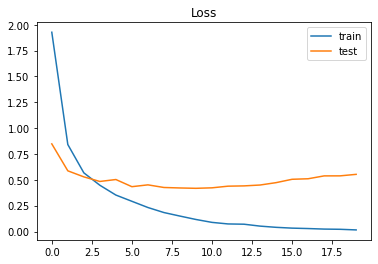

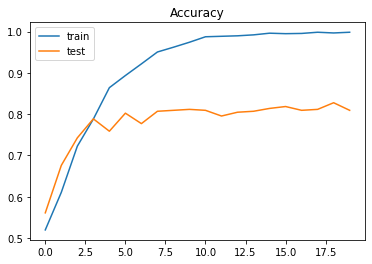

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(evals_tensors)

y_preds = []
y_preds_train = []
for i in [round(i[0],0) for i in Y_pred]:
    if i > 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)
        
for i in [round(i[0],0) for i in Y_pred_train]:
    if i > 0.5:
        y_preds_train.append(1)
    else:
        y_preds_train.append(0)

print('Confusion Matrix - Test Set')
print(confusion_matrix(y_test.values.tolist(), y_preds))
print('Confusion Matrix - Evaluation Set')
print(confusion_matrix(evals_targets.values.tolist(), y_preds_train))


print('Classification Report - Test Set')
print(classification_report(y_test.values.tolist(), y_preds, target_names=['Shaved','Unshaved']))
print('Classification Report - Evaluation Set')
print(classification_report(evals_targets.values.tolist(), y_preds_train, target_names=['Shaved','Unshaved']))


Confusion Matrix - Test Set
[[155  42]
 [ 41 197]]
Confusion Matrix - Evaluation Set
[[ 0  0]
 [13 87]]
Classification Report - Test Set
              precision    recall  f1-score   support

      Shaved       0.79      0.79      0.79       197
    Unshaved       0.82      0.83      0.83       238

    accuracy                           0.81       435
   macro avg       0.81      0.81      0.81       435
weighted avg       0.81      0.81      0.81       435

Classification Report - Evaluation Set
              precision    recall  f1-score   support

      Shaved       0.00      0.00      0.00         0
    Unshaved       1.00      0.87      0.93       100

    accuracy                           0.87       100
   macro avg       0.50      0.43      0.47       100
weighted avg       1.00      0.87      0.93       100



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Saving Final Model 

Now that we have a solid model that performs well on unseen images, we can save this model, and the weights. This will allow us to deploy this model, or even share the file with others interested in similar projects. 

In [0]:
## saving model 
model_json = model.to_json() 
with open("/content/drive/My Drive/CNN_model_Final.json", "w") as json_file:
    json_file.write(model_json)
## saving weights
model.save_weights("/content/drive/My Drive/CNN_model_Final.h5")

## loading model 

from keras.models import model_from_json
## loading model 
json_file = open('/content/drive/My Drive/CNN_model_Final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
## loading weights
loaded_model.load_weights("/content/drive/My Drive/CNN_model_Final.h5")
## compile model
loaded_model.compile(loss='binary_crossentropy', 
                       optimizer='adam', metrics=['accuracy'])

# Saving whole model

model.save('/content/drive/My Drive/whole_model_CNN.h5')

from keras.models import load_model
loaded_model = load_model('/content/drive/My Drive/whole_model_CNN.h5')
loaded_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', metrics=['accuracy'])

res2 = loaded_model.predict(evals_tensors)
results2= []
for i in res2:
    results2.append(round(i[0],2))
compare = zip(results2, evals_targets)


## Viewing the comparison

In [0]:
for i in compare:
  print(i)

(1.0, 1)
(0.95, 1)
(1.0, 1)
(0.97, 1)
(0.99, 1)
(1.0, 1)
(0.99, 1)
(0.17, 1)
(1.0, 1)
(0.96, 1)
(1.0, 1)
(1.0, 1)
(0.99, 1)
(0.0, 1)
(1.0, 1)
(0.99, 1)
(1.0, 1)
(1.0, 1)
(1.0, 1)
(0.91, 1)
(1.0, 1)
(1.0, 1)
(0.97, 1)
(1.0, 1)
(0.4, 1)
(1.0, 1)
(0.31, 1)
(0.93, 1)
(1.0, 1)
(0.81, 1)
(1.0, 1)
(0.02, 1)
(0.75, 1)
(0.84, 1)
(0.96, 1)
(1.0, 1)
(0.67, 1)
(0.99, 1)
(0.0, 1)
(0.97, 1)
(0.99, 1)
(1.0, 1)
(0.99, 1)
(1.0, 1)
(0.99, 1)
(0.68, 1)
(0.99, 1)
(1.0, 1)
(0.15, 1)
(0.99, 1)
(0.98, 1)
(0.18, 1)
(0.09, 1)
(0.99, 1)
(0.38, 1)
(0.79, 1)
(0.6, 1)
(0.98, 1)
(1.0, 1)
(0.99, 1)
(0.6, 1)
(1.0, 1)
(0.99, 1)
(0.97, 1)
(0.96, 1)
(1.0, 1)
(0.99, 1)
(0.99, 1)
(1.0, 1)
(0.0, 1)
(1.0, 1)
(0.98, 1)
(0.98, 1)
(0.97, 1)
(0.91, 1)
(1.0, 1)
(1.0, 1)
(0.83, 1)
(0.99, 1)
(0.97, 1)
(0.79, 1)
(1.0, 1)
(0.5, 1)
(0.82, 1)
(0.99, 1)
(0.99, 1)
(1.0, 1)
(1.0, 1)
(1.0, 1)
(0.97, 1)
(0.82, 1)
(0.07, 1)
(1.0, 1)
(0.89, 1)
(1.0, 1)
(0.93, 1)
(0.21, 1)
(1.0, 1)
(1.0, 1)
(0.99, 1)


# Conclusion

Now let's review. First, we imported our libraries and imageset. We then defined and scaled our feature before storing them in a tensor; one-hot encoded our target variables; then split our data into train/test/evaluation sub-sets. We built our CNN; fit the model to our imageset and compiled the model using the adam optimizer, with a binary_crossentropy loss fuction using the accuracy metric to improve during forward and backwards propogation. . 

After training was complete, we evaluated the metrics and visualized the results before saving the model and weights for future use. The next step in our process is deploying our model for public use. We will use flask to build a python application, and host it on Heroku. 
